In [2]:
#importing the necessary dependencies

import numpy as np
import sys
import scipy
from numpy import array
caffe_root = '/path/to/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe.proto import caffe_pb2
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import os
import math

%matplotlib inline

In [3]:
#initializing the model

#Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

# BGR mean values
mean = np.array([103.939, 116.779, 123.68])

net = caffe.Classifier('../models/resnet_101/deploy.prototxt','../models/resnet_101/ResNet-101-model.caffemodel',channel_swap=(2,1,0))

In [8]:
#Member Fuctions

#To backtrack from the loss layer upto the last residual block
def start(crop, label):
        weights = net.params['fc1000'][0].data[label]
        data = net.blobs['pool5'].data[crop,:,0,0]
        conv = data*weights
        num = np.sum(conv>0) #choosing all positive elements
        val = np.argsort(conv)[:num]
        layer_out = []
        for i in val:
                x, y = np.unravel_index(np.argmax(net.blobs['res5c'].data[crop,i,:,:]), [7,7])
                layer_out.append((i,x,y))
        return list(set(layer_out))

#function to backtrack between two consecutive residual blocks
def res2res(crop, layer_in, layer_prefix, prev_layer_prefix):
        layer_out = []
        flag = False #flag to check if previous block downsampled the inputs
        if 'a' in layer_prefix:
                flag = True
                # Getting activations from previous residual block
                branch_skip = net.blobs['res'+layer_prefix+'_branch1'].data[crop]
        else:
                branch_skip = net.blobs['res'+prev_layer_prefix].data[crop]
        # Getting activations from all convolution layers inside the residual block
        branch_res_blobs = [net.blobs['res'+layer_prefix+'_branch2a'].data[crop], net.blobs['res'+layer_prefix+'_branch2b'].data[crop], net.blobs['res'+layer_prefix+'_branch2c'].data[crop]]
        # Pad input to 3x3 block so the size remains same after conv
        branch_res_blobs[0] = np.lib.pad(branch_res_blobs[0], 1 ,'constant',constant_values=0)[1:-1,:,:]
        for i in layer_in:
                # To check if the higher activation at a point came from skip or delta branch
                if branch_skip[i[0],i[1],i[2]] >= branch_res_blobs[2][i[0],i[1],i[2]]:
                        if flag:
                                weights = net.params['res'+layer_prefix+'_branch1'][0].data[i[0],:,0,0]
                                if prev_layer_prefix == 'pool1':
                                        data = net.blobs[prev_layer_prefix].data[crop,:,i[1],i[2]]
                                        feature = np.argmax(data*weights)
                                        layer_out.append((feature,i[1],i[2]))
                                else:
                                        data = net.blobs['res'+prev_layer_prefix].data[crop,:,i[1]*2,i[2]*2]
                                        feature = np.argmax(data*weights)
                                        layer_out.append((feature,i[1]*2,i[2]*2))
                        else:
                                layer_out.append(i)
                else:
                        weights = net.params['res'+layer_prefix+'_branch2c'][0].data[i[0],:,0,0]
                        feature = np.argmax(branch_res_blobs[1][:,i[1],i[2]]*weights)
                        weights = net.params['res'+layer_prefix+'_branch2b'][0].data[feature,:,:,:]
                        data = branch_res_blobs[0][:,i[1]:i[1]+3,i[2]:i[2]+3]
                        feature = np.argmax(np.sum(np.sum(data*weights,axis=2),axis=1))
                        x, y = np.unravel_index(np.argmax(data[feature,:,:]),data[feature,:,:].shape)
                        if flag:
                                weights = net.params['res'+layer_prefix+'_branch2a'][0].data[feature,:,0,0]
                                if prev_layer_prefix =='pool1':
                                        feature = np.argmax(net.blobs[prev_layer_prefix].data[crop,:,i[1]+x-1,i[2]+y-1]*weights)
                                        layer_out.append((feature,i[1]+x-1,i[2]+y-1))
                                else:
                                        feature = np.argmax(net.blobs['res'+prev_layer_prefix].data[crop,:,(i[1]+x-1)*2,(i[2]+y-1)*2]*weights)
                                        layer_out.append((feature,(i[1]+x-1)*2,(i[2]+y-1)*2))
                        else:
                                weights = net.params['res'+layer_prefix+'_branch2a'][0].data[feature,:,0,0]
                                feature = np.argmax(branch_skip[:,i[1]+x-1,i[2]+y-1]*weights)
                                layer_out.append((feature,i[1]+x-1,i[2]+y-1))
        return list(set(layer_out))

#to backtrack evidence from last conv to image
def end(crop, layer_in, inc, resFac):
        data = net.blobs['conv1'].data[crop]
        img_layer = np.lib.pad(net.blobs['data'].data[crop], 3 ,'constant',constant_values=0)[3:-3,:,:]
        weights = net.params['conv1'][0].data
        layer_out = ''
        for i in layer_in:
                x, y = np.unravel_index(np.argmax(data[i[0],2*i[1]:2*i[1]+3,2*i[2]:2*i[2]+3]),[3,3])
                loc = [2*i[1]+x,2*i[2]+y]
                feature = np.argmax(np.sum(np.sum(img_layer[:,loc[0]:loc[0]+7,loc[1]:loc[1]+7]*weights[i[0],:,:,:],axis=2),axis=1))
                x, y = np.unravel_index(np.argmax(img_layer[feature,loc[0]:loc[0]+7,loc[1]:loc[1]+7]),img_layer[feature,loc[0]:loc[0]+7,loc[1]:loc[1]+7].shape)
                layer_out += ' '+str(int(((2*loc[0]+x-3)+inc[crop][0])*(1/resFac)))+' '+str(int(((2*loc[1]+y-3)+inc[crop][1])*(1/resFac)))
        return layer_out

def call(crop, index, inc, resFac):
        blob_list = ['pool1', '2a', '2b', '2c', '3a', '3b1', '3b2', '3b3', '4a', '4b1', '4b2', '4b3', '4b4', '4b5', '4b6', '4b7', '4b8', '4b9',
         '4b10', '4b11', '4b12', '4b13', '4b14', '4b15', '4b16', '4b17', '4b18', '4b19', '4b20', '4b21', '4b22', '5a', '5b', '5c']
        val = start(crop, index)
        for i in range(len(blob_list)-1,0,-1):
                val = res2res(crop, val, blob_list[i], blob_list[i-1])
        val = end(crop, val, inc, resFac)
        return val                
        
def out_rem(pts, diag):
    values = pts
    neighbors = np.zeros((values.shape[0]))
    selPoints = np.empty((1,2))
    for i in range(values.shape[0]):
        diff = np.sqrt(np.sum(np.square(values-values[i]),axis=1))
        neighbors[i] = np.sum(diff<diag)
    for i in range(values.shape[0]):
        if neighbors[i]>0.05*values.shape[0]:
            selPoints = np.append(selPoints,values[i:i+1,:],axis=0)
    selPoints = selPoints[1:,:]
    selPoints = selPoints.astype(int)
    return selPoints

def heatmap(img, pts, sigma=20):
    k = (np.min(img.shape[:2])) if (np.min(img.shape[:2])%2==1) else (np.min(img.shape[:2])-1)
    mask = np.zeros(img.shape[:2])
    shape = mask.shape
    for i in range(pts.shape[0]):
        if pts[i,0]<shape[0] and pts[i,1]<shape[1]:
            mask[pts[i,0],pts[i,1]] += 1
    blur = cv2.GaussianBlur(mask,(k,k),sigma)
    blur = blur*255/np.max(blur)
    return blur

In [22]:
#loading ilsvrc synset
synsets = open('ilsvrc_synsets.txt').readlines()

#Put the path to test image here
img_path = '../../universal_perturbation/data/ilsvrc_val/ILSVRC2012_val_00000001.JPEG'
img=caffe.io.load_image(img_path)

#Preprocessing the image
resFac = 256.0/min(img.shape[:2])
newSize = map(int,(img.shape[0]*resFac,img.shape[1]*resFac))
img = transform.resize(img, newSize)
net.image_dims = newSize
#The offsets for the crops
inc = [[0,0],[0,newSize[1]-224],[newSize[0]-224,0],[newSize[0]-224,newSize[1]-224],[newSize[0]/2.0-112,newSize[1]/2.0-112]]
img = img*255.0
img[:,:,0]-=mean[2]
img[:,:,1]-=mean[1]
img[:,:,2]-=mean[0]
#Passing image through network
net.predict([img],oversample=True)
p = net.blobs['prob'].data
#The mean label
p_mean = np.argmax(np.mean(p,axis=0))
image_label = synsets[p_mean].split(',')[0].strip()
image_label = image_label[image_label.index(' ')+1:]
crop_labels = [np.argmax(p[0]),np.argmax(p[1]),np.argmax(p[2]),np.argmax(p[3]),np.argmax(p[4])]
#To check if mean label does not match any crop
if p_mean in crop_labels:
    p_m = p_mean
else:
    p_m = crop_labels[4]
crops = []
#To check which crops to consider
for i in range(5):
    if np.argmax(p[i,:])==p_m:
        crops.append(1)
    else:
        crops.append(0)
output = ''  
for cr in range(5):
    if crops[cr]==1:
            output += call(cr, p_mean, inc, resFac)

(<matplotlib.image.AxesImage at 0x7f279e8db710>,
 (-0.5, 499.5, 374.5, -0.5),
 <matplotlib.text.Text at 0x7f279e64a3d0>)

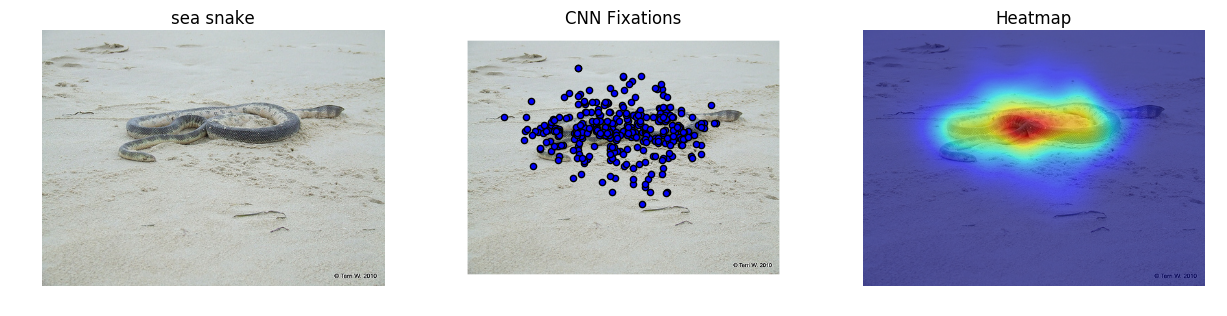

In [23]:
#Visualization
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
diag = math.sqrt(img.shape[0]**2 + img.shape[1]**2)*0.1
values = np.reshape(np.asarray(map(int,output.strip().split())),[-1,2])
selPoints = out_rem(values, diag)
hm = heatmap(np.copy(img), selPoints)

_, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img),ax[0].axis('off'),ax[0].set_title(image_label)
ax[1].imshow(img),ax[1].axis('off'),ax[1].scatter(selPoints[:,1],selPoints[:,0]),ax[1].set_title('CNN Fixations')
ax[2].imshow(img),ax[2].imshow(hm, alpha=0.6),ax[2].axis('off'),ax[2].set_title('Heatmap')